In [101]:
# Imports

import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.cancorr import CanCorr
import warnings
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = "notebook"

#### Load data

In [102]:
# Read data

data_folder = "../data/processed/"
df_social = pd.read_csv(data_folder + "socio_extrapolated_5_country.csv", index_col=0)
df_energy = pd.read_csv(data_folder + "pcc_energy_extrapolated_5_country.csv", index_col=0)

#### Data preprocessing

In [103]:
# Make sure both energy and social data keys (entity, year) are present in both datasets. Otherwise drop those records
temp1 = list(zip(df_energy[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Entity'],
                 df_energy[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Year']))
temp2 = list(zip(df_social[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Entity'],
                 df_social[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Year']))
exclude_records1 = list(set(temp2) - set(temp1))
exclude_records = list(set(temp1) - set(temp2))

# Comprehensive list of keys from both datasets, that is not a part the intersection
exclude_records.extend(exclude_records1)

# Extract keys
list_energy = list(zip(df_energy['Entity'],df_energy['Year']))
list_social = list(zip(df_social['Entity'],df_social['Year']))

# Get list of all keys, that should not be excluded
list_in_energy = [x not in exclude_records for x in list_energy]
list_in_social = [x not in exclude_records for x in list_social]

# Drop unwanted records and sort remaining data (so energy and social data align in index)
df_energy = df_energy.iloc[list_in_energy,].reset_index().drop(columns='index')
df_social = df_social.iloc[list_in_social,].reset_index().drop(columns='index')
df_energy = df_energy.sort_values(['Entity','Year']).reset_index().drop(columns='index')
df_social = df_social.sort_values(['Entity','Year']).reset_index().drop(columns='index')

In [104]:
# Extract records, where we have zero nan values (combined between the two datasets) - only for columns of interest
df_energy_sub = df_energy.iloc[:,[5,6]]
df_social_sub = df_social.iloc[:,[0,1,2,5,6,8,9,10,12,13,14]]

energy_non_nan_indx = df_energy_sub.isna().sum(axis=1)==0
social_non_nan_indx = df_social_sub.isna().sum(axis=1)==0

indx_non_nan = energy_non_nan_indx & social_non_nan_indx

df_energy_sub = df_energy_sub.iloc[np.array(indx_non_nan),].reset_index().drop(columns='index')
df_social_sub = df_social_sub.iloc[np.array(indx_non_nan),].reset_index().drop(columns='index')

In [105]:
# Due to numerical instability with too large values, we will work with log(population)
df_social_sub.iloc[:,4] = df_social_sub.iloc[:,4]/1e6

#### Define features and target values

In [106]:
# Define target values and features
X = df_social_sub
y = df_energy_sub['Low-carbon energy per capita (kWh)']/df_energy_sub['Energy per capita (kWh)'] + 1e-7

In [107]:
# Select data 
Continent = 'all'
year_max = 2019
year_min = 2000

X1 = X.copy()
y1 = y.copy()

if Continent == 'all':
    X1 = X1[(X['Year'] <= year_max) & (X['Year'] >= year_min)]
    y1 = y1[(X['Year'] <= year_max) & (X['Year'] >= year_min)]

    X1 = pd.concat([X1,pd.get_dummies(X1.Continent, prefix='Continent')],axis=1)
else:
    X1 = X1[(X['Year'] <= year_max) & (X['Year'] >= year_min) & (X['Continent'] == Continent)]
    y1 = y1[(X['Year'] <= year_max) & (X['Year'] >= year_min) & (X['Continent'] == Continent)]

X1 = X1.reset_index().drop(columns='index')
y1 = y1.reset_index().drop(columns='index')

# Drop years and continent from features dataset
X2 = X1.iloc[:,3:]

#### Find optimal number of PLS components

Text(0.5, 1.0, 'hp')

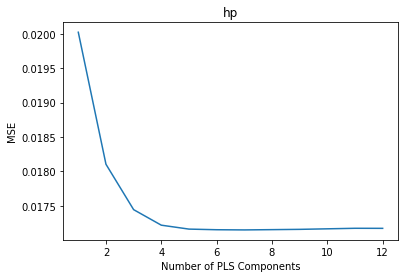

In [108]:
# Get training and test set
X_train,X_test,y_train,y_test = train_test_split(X2,y1,test_size=0.3,random_state=0) 

#define cross-validation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Ignore runtime warning (divide by zero)

    # Calculate MSE using cross-validation, adding one component at a time
    for i in np.arange(1, 13):
        pls = PLSRegression(n_components=i)
        score = -1*model_selection.cross_val_score(pls, scale(X_train), y_train, cv=cv,
                scoring='neg_mean_squared_error').mean()
        mse.append(score)

#plot test MSE vs. number of components
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(np.arange(1,len(mse)+1,1),mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')

#### Train and test model performance

In [109]:
#calculate RMSE
pls = PLSRegression(n_components=np.argmin(mse)+1)
X_mean = X_train.mean()
X_std = X_train.std()
pls.fit(scale(X_train), y_train)

X_test_std = (X_test-X_mean)/X_std
np.sqrt(mean_squared_error(y_test, pls.predict(X_test_std.to_numpy())))

0.13667850558601294

<AxesSubplot:>

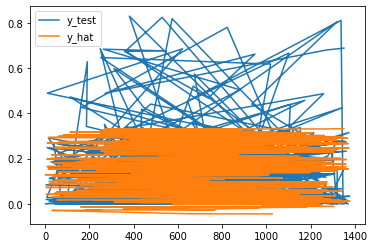

In [110]:
y_test_dat = y_test.to_numpy().ravel()
y_hat_dat = pls.predict(X_test_std.to_numpy()).ravel()

sort_indx = np.argsort(y_hat_dat)
y_test_sorted = y_test_dat[sort_indx]
y_hat_sorted = y_hat_dat[sort_indx]

test_data = pd.DataFrame({'y_test':y_test_sorted,'y_hat':y_hat_sorted, 'y_cont':X1['Continent'].iloc[X_test.index]})
test_data.plot()

In [111]:
y_cont = test_data.y_cont
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(y_cont.unique())))

mapping = {}
for indx, cont in enumerate(np.sort(y_cont.unique())):
    mapping[cont] = colors[indx]

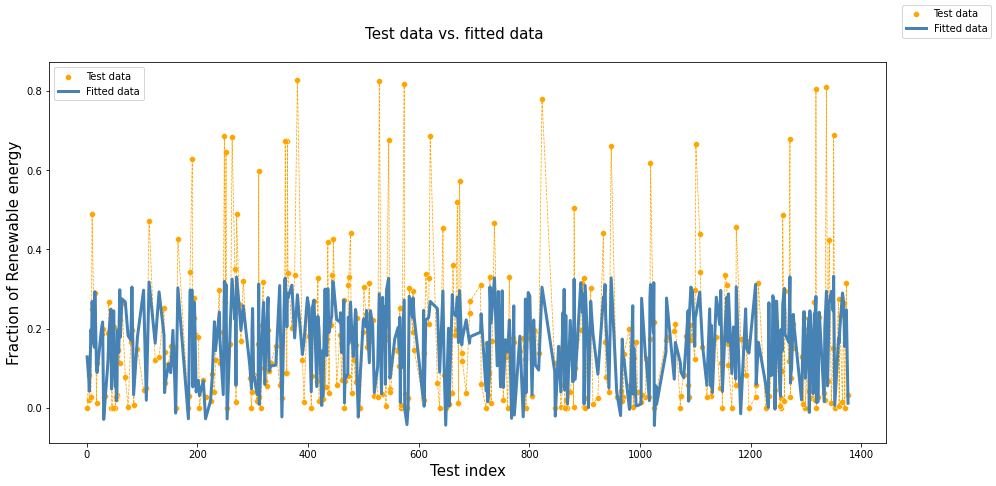

In [112]:
y_cont = X1['Continent'].iloc[X_test.index]
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(y_cont.unique())))

mapping = {}
for indx, cont in enumerate(y_cont.unique()):
    mapping[cont] = colors[indx]

col_map = [mapping[cont] for cont in y_cont]

fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=test_data, x=test_data.index, y='y_test',ax=ax, linewidth=0.75, color='orange', linestyle='--')
sns.scatterplot(data=test_data,x=test_data.index,y='y_test',ax=ax, color='orange', label='Test data')
sns.lineplot(data=test_data, x=test_data.index, y='y_hat',ax=ax, color='steelblue', linewidth=3, label='Fitted data')
ax.set_ylabel('Fraction of Renewable energy', fontsize=15)
ax.set_xlabel('Test index', fontsize=15)
fig.suptitle('Test data vs. fitted data', fontsize=15, y=0.95)
fig.legend()

#### Find R2 value of model

In [113]:
SSres = np.sum((test_data.y_test-test_data.y_hat)**2)
SStot = np.sum((test_data.y_test-np.mean(test_data.y_test))**2)

R2 = 1-SSres/SStot
print(f'R2 value is: {R2:.3f}')
print(f'The correaltion coefficient between the predicted and test values is: {np.corrcoef(test_data.y_test,test_data.y_hat)[1,0]:.3f}')

R2 value is: 0.350
The correaltion coefficient between the predicted and test values is: 0.592


#### PLS components scores

In [114]:
pls.y_loadings_

array([[ 0.21471252,  0.27201768,  0.21305102, -0.10366524,  0.06407632,
         0.0331531 ,  0.02122158]])

#### Analysis of PLS components

In [115]:
n_comp = 3

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Ignore runtime warning (divide by zero)
    loadings=pd.DataFrame(pls.x_loadings_.T)
    loadings.columns = X2.columns

    loadings_v = loadings.unstack().reset_index()
    loadings_v.columns = ['Feature','PLS Component','Loading']

    loadings_v = loadings_v[loadings_v['PLS Component'] < n_comp]
    loadings_v['Continent'] = np.array(['Continent' in x for x in loadings_v['Feature']])
    loadings_v['x'] = np.zeros(len(loadings_v['Feature']),)
    loadings_v['PLS Component'] = loadings_v['PLS Component']+1

    loadings_v_social = loadings_v.iloc[['Continent' not in x for x in loadings_v['Feature']],:]
    loadings_v_continent = loadings_v.iloc[['Continent' in x for x in loadings_v['Feature']],:]
    loadings_v_continent.rename(columns={'Feature':'Continent'},inplace=True)
    #loadings_v_continent.loc[:,'Continent'] = np.array([x.split('_')[1] for x in loadings_v_continent['Continent']])

In [116]:
social_feats = pd.Series([x for x in loadings_v['Feature'] if 'Continent' not in x]).unique()
continents = pd.Series([x for x in loadings_v['Feature'] if 'Continent' in x]).unique()
continents = np.array([x.split('_')[1] for x in continents])
loadings_v = loadings_v.reset_index().drop(columns='index')

for indx,feat in enumerate(loadings_v['Feature']):
    if "Continent" in feat:
        loadings_v.loc[indx,'Feature'] = feat.split('_')[1]

In [117]:
loadings_v

,Feature,PLS Component,Loading,Continent,x
0,GDP per capita ($),1,0.268304,False,0.0
1,GDP per capita ($),2,-0.386097,False,0.0
2,GDP per capita ($),3,0.541340,False,0.0
3,Child mortality rate (under 5 years - %),1,-0.365907,False,0.0
4,Child mortality rate (under 5 years - %),2,0.233106,False,0.0
5,Child mortality rate (under 5 years - %),3,0.254849,False,0.0
6,Population,1,-0.161401,False,0.0
7,Population,2,0.161067,False,0.0
8,Population,3,0.467204,False,0.0
9,HDI,1,0.402705,False,0.0


In [176]:
comp = 3
colormap = {}
for indx,i in enumerate(social_feats):
    colormap[i] = px.colors.qualitative.Pastel[indx]
for indx,i in enumerate(continents):
    colormap[i] = px.colors.qualitative.Antique[indx]


fig = px.bar(loadings_v[loadings_v['PLS Component'] == comp], x="x", y="Loading", color="Feature", barmode='group',
             facet_col='Continent', facet_col_wrap=1, color_discrete_map=colormap,
             category_orders={'Continent':[True, False]},
             labels={'x':''},
             width=1300, height=500,
             facet_row_spacing = 0.125,
             hover_name="Feature",hover_data={"Loading": True,
                                              "Feature": False,
                                              "Continent": False,
                                              "x":False,
                                              "PLS Component":False})

fig.update_layout(
    xaxis = dict(
        showticklabels=False
    ),
    xaxis2 = dict(
        showticklabels=False
    ),
    xaxis3 = dict(
        showticklabels=False
    )
)

fig.update_layout(
    margin=dict(l=40, r=750, t=40, b=40)
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=1.05
))

if comp == 1:
    anno_text = str(f'<b>PLS Component 1</b><br><br>'+
                    f'The correlation coefficient <br>with the target variable is: <b>{pls.y_loadings_[0][0]:.3f}' + 
                    '</b><br><br>For the continents, we see that it<br>'+
                    '<b>positively</b> correlates with <b>Europe</b>, while<br>'+ 
                    'it <b>negatively</b> correlates with <b>Asia</b>. For<br>'+
                    'the social/economic metrics, we see<br>'+
                    'high <b>positive</b> loadings in measures<br>'+
                    'related do <b>high development</b>, while we<br>'+
                    'have <b>negative</b> correlation for <b>child<br>'+
                    'mortality</b> and <b>population</b>. It seems like<br>'+
                    'this component captures <b>European</b> countries<br>'+
                    'that are <b>highly developed</b> and puts it in<br>'+
                    'opposition to <b>Asian</b> countries. <br><br>'+
                    'An example of such a country could be <br>'+
                    '<b>Iceland.</b>')

elif comp == 2:
    anno_text = str(f'<b>PLS Component 2</b><br><br>'+
                    f'The correlation coefficient <br>with the target variable is: <b>{pls.y_loadings_[0][1]:.3f}' + 
                    '</b><br><br>Looking at the continents, we see that<br>'+
                    'this component seems to represent <b>South<br>'+ 
                    'American</b> countries, putting it in<br>'+
                    'opposition to <b>Asia</b>. For the social/economic<br>'+
                    'measures, we see something interesting.<br>'+
                    'Despite the component correlating<br>'+
                    '<b>positively</b> with the response, we have<br>'+
                    '<b>negative</b> correlations for many of the<br>'+
                    'measures. This seems to suggest that<br>'+
                    'the <b>South American</b> can have a relatively<br>'+
                    '<b>high fraction of renewables</b> despite<br>'+
                    'scoring low in the social/economic domain.<br><br>'+
                    'A good example of this situation is <b>Brazil</b>.')

else:
    anno_text = str(f'<b>PLS Component 3</b><br><br>'+
                    f'The correlation coefficient <br>with the target variable is: <b>{pls.y_loadings_[0][2]:.3f}' + 
                    '</b><br><br>Here, it looks like the component<br>'+
                    'are very <b>populous</b> and are <b>relatively,<br>'+
                    'developed</b> while also somewhat<br>' +
                    'representing <b>Oceania</b>. It also seems<br>'+
                    'like <b>African</b> countries (in particular)<br>' +
                    'in this component show the opposite <br>'+
                    'trend than the <b>Asian</b> ones.<br><br>'+
                    'An example of a country that fits <br>'+
                    'this description is <b>China</b>.')

                    
                      
                      
                       
                     

fig.add_annotation(
    yanchor="top",
    xanchor="left",
    yref = 'paper',
    xref = 'paper',
    x=1.665,
    y=1,
    text=anno_text,
    font=dict(family="Courier New, monospace", size=16, color="Black"),
    align="left",
    bordercolor="Black",
    borderwidth=1,
    borderpad=4,
    bgcolor="#EBECF0",
    showarrow=False,
    opacity=0.8,
)

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=True", "<b>Continents</b>")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=False", "<b>Social metrics</b>")))
    
fig.show()

In [ ]:
y_loadings = pd.read_csv("../data/model_results/y_loadings_v.csv", index_col=0)
y_loadings.iloc[0,0]

In [ ]:
px.bar()

In [ ]:
loadings_v

In [ ]:
loadings=pd.DataFrame(pls.x_loadings_.T)
loadings.columns = X2.columns

#sns.barplot()

loadings.iloc[0:3,:].plot.bar(figsize=(13,7),xlabel='PLS component',ylabel='Feature loadings').legend(loc='right',bbox_to_anchor=(1.5,0.5))

In [ ]:
pls.y_weights_

In [ ]:
# first component. x and y are plotted seperately due to large size in x
# 1e6 seems extreme. don't know whats wrong 
n = 3
print(pls.x_loadings_[n])
plt.bar(x=np.arange(0,len(pls.x_loadings_[n])), height=pls.x_loadings_)

In [ ]:
ca.x_loadings_.shape

In [ ]:
ca.y_loadings_.shape

In [ ]:
for i in range(n_features):
    plt.plot(ca.x_loadings_[i])


In [ ]:
for i in range(n_features):
    plt.plot(ca.y_loadings_[i])

In [ ]:
# pairwise canonical correlations 
np.corrcoef(E_c.T, S_c.T).diagonal(offset=n_features)
# we see quite high correlation in the first and second canonical component. let's plot the corresponding loadings 
# to investigate further


In [ ]:
# first component. x and y are plotted seperately due to large size in x
# 1e6 seems extreme. don't know whats wrong 
n = 0
print(ca.x_loadings_[n])
plt.bar(x=np.arange(0,len(ca.x_loadings_[n])), height=ca.x_loadings_[n])

In [ ]:
print(ca.y_loadings_[n])
plt.bar(x=np.arange(0,len(ca.y_loadings_[n])), height=ca.y_loadings_[n])

In [ ]:
# second component
n = 1
print(ca.x_loadings_[n])
plt.bar(x=np.arange(0,len(ca.x_loadings_[n])), height=ca.x_loadings_[n])

In [ ]:
print(ca.y_loadings_[n])
plt.bar(x=np.arange(0,len(ca.y_loadings_[n])), height=ca.y_loadings_[n])

In [ ]:
E.columns

In [ ]:
E.describe()

In [ ]:
(df_energy_sub - df_energy_sub.mean())/df_energy_sub.std()

In [ ]:
df_energy

In [ ]:
sns.heatmap(np.corrcoef(df_energy.iloc[:,4:].fillna(0).T), annot=True, fmt=".1g")

In [ ]:
df_energy.iloc[:,4:].columns

In [ ]:
plt.scatter(ca.x_loadings_[b])

In [ ]:
plt.scatter(E_c[:,0], S_c[:,0])

In [ ]:
plt.scatter(E_c[:,1], S_c[:,1])

In [ ]:
# try with statsmodels instead 
res = CanCorr(E, S)

In [ ]:
test =  res.corr_test()

In [ ]:
test.summary()

In [ ]:
res.y_cancoef
# same problem with very high values as for the sklearn solution 

In [ ]:
res.x_cancoef